# Classification based on leaves images

### Importing our own functions

In [2]:
import importlib

import src.Data as Data
importlib.reload(Data)
Data = Data.Data

### libraries

In [3]:
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

### Loading the data

In [4]:
data: Data = Data(test_size=0.2, include_images=True)

Leafs speacies from the dataset : 


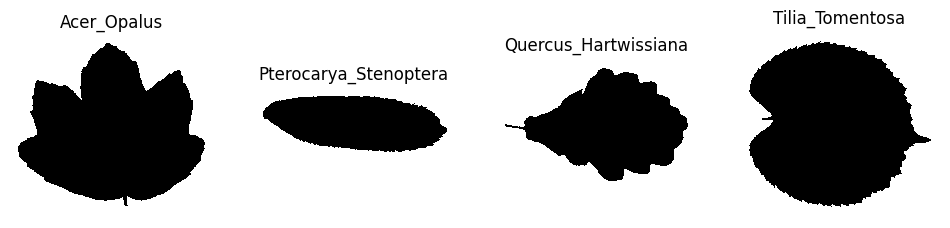

In [5]:
print('Leafs speacies from the dataset : ')
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, image, label in zip(axes, data.x_image_tab, data.y_tab):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{label}')

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# Creating a classifier: a support vector classifier
classifiers = [
    RandomForestClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1),
    SGDClassifier(n_jobs=-1), 
    # LogisticRegression(n_jobs=-1),    # Crash
]

# Fitting the classifier on the training set
for clf in classifiers:
    clf.fit(data.x_image_train, data.y_train)

# Predicting the species on the test set
predicted = [clf.predict(data.x_image_test) for clf in classifiers]

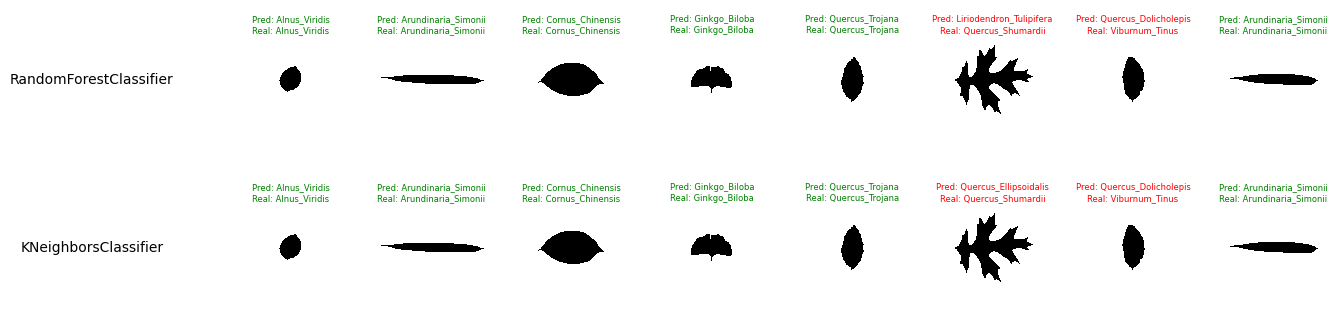

In [10]:
# Plotting the predictions and the ground truth on top of the images for each classifier
_, axes = plt.subplots(nrows=len(classifiers), ncols=9, figsize=(16, 2*len(classifiers)))
for i, clf in enumerate(classifiers):
    clf_name = clf.__class__.__name__
    for ax, image, prediction, actual_label in zip(axes[i][1:], data.x_image_test, predicted[i][:8], data.y_test):
        ax.set_axis_off()
        image = image.reshape(data.resized_images_width, data.resized_images_height)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        if prediction == actual_label:
            ax.set_title(f'Pred: {prediction}\nReal: {actual_label}', fontsize=6, color='green')
        else:
            ax.set_title(f'Pred: {prediction}\nReal: {actual_label}', fontsize=6, color='red')
    axes[i][0].set_axis_off()
    axes[i][0].text(0, 0.5, clf_name, fontsize=10, ha='center', va='center')

In [11]:
for (clf, pred) in zip(classifiers, predicted):
    print(
        f"Classification report for classifier {clf}:\n"
        f"{metrics.classification_report(data.y_image_test, pred)}\n"
    )

Classification report for classifier RandomForestClassifier(n_jobs=-1):
                              precision    recall  f1-score   support

             Acer_Capillipes       0.40      1.00      0.57         2
             Acer_Circinatum       1.00      1.00      1.00         2
                   Acer_Mono       1.00      1.00      1.00         2
                 Acer_Opalus       1.00      1.00      1.00         2
               Acer_Palmatum       0.67      1.00      0.80         2
                 Acer_Pictum       1.00      1.00      1.00         2
             Acer_Platanoids       1.00      1.00      1.00         2
                 Acer_Rubrum       0.33      0.50      0.40         2
              Acer_Rufinerve       0.67      1.00      0.80         2
            Acer_Saccharinum       0.00      0.00      0.00         2
               Alnus_Cordata       1.00      1.00      1.00         2
          Alnus_Maximowiczii       0.33      0.50      0.40         2
                 

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: Undefin